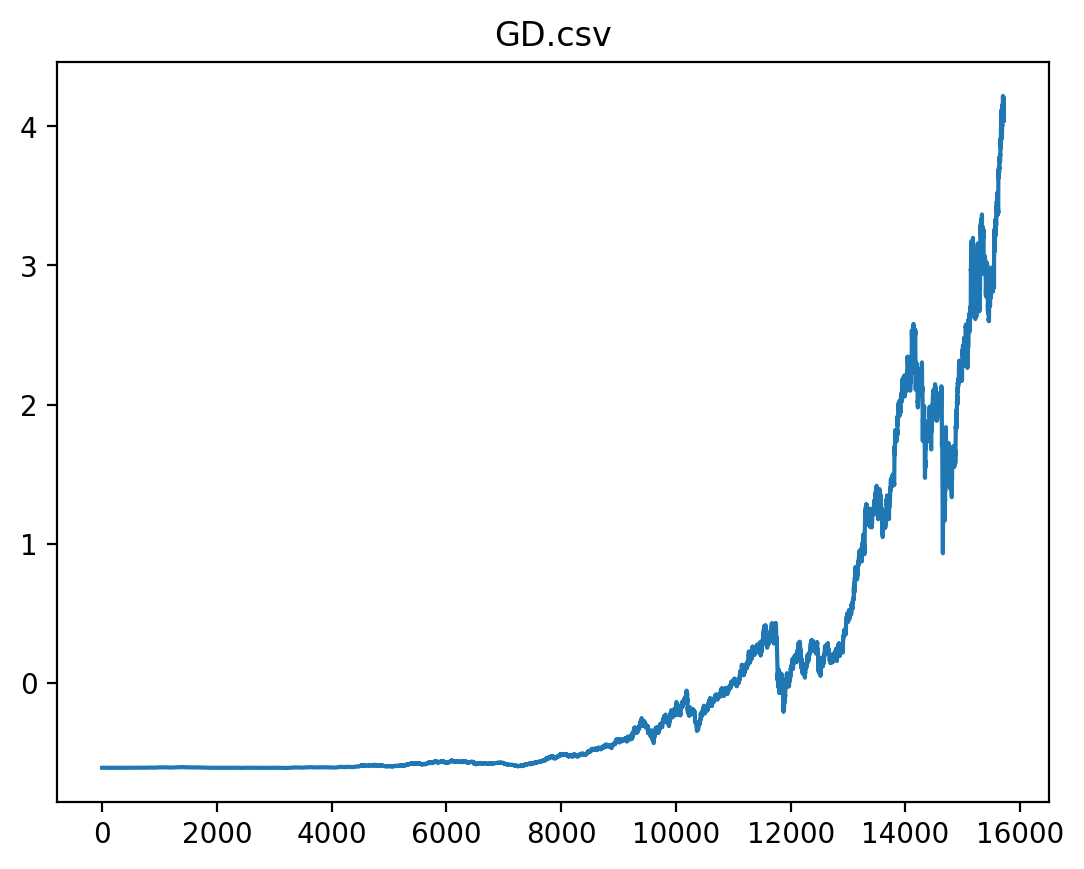

In [13]:
from matplotlib import pyplot as plt
from torch import optim
from torch import nn
import pandas as pd

%config InlineBackend.figure_format='retina'


y = pd.read_csv("GD.csv")
y = y.iloc[:, -2].to_numpy()
y = (y - y.mean()) / y.std()

plt.title("GD.csv")
plt.plot(y)
plt.show()

In [14]:
# data
num_samples = int(1e4)
seasonal_period = 900
n_epochs = 100

from models.FITS import FITS

from argparse import Namespace

base_freq = 120
cut_off_harmonic = 10
cutoff_freq = int((240 / base_freq) * cut_off_harmonic)

args = Namespace(
    dominance_freq=cutoff_freq,
    seq_len=240,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
)

print(args.dominance_freq)
model = FITS(args)

print(model)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

20
FITS(
  (frequency_upsampler): Linear(in_features=20, out_features=30, bias=True)
)


In [15]:
import numpy as np
import torch
from torch import nn

early_stopping = False

def train(model, model_optim, n_channels, y, num_samples, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    min_delta = 0.0001  # minimum change to qualify as an improvement
    criterion = nn.MSELoss()

    for epoch in range(n_epochs):  # train 1000 epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * 80 : (batch + 1) * 80
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + 240 + 120])

            batch_xy = np.array(batch).reshape(
                80, 360, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :240, :]
            batch_y = batch_xy[:, 240:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            train_loss.append(loss.item())

            loss.backward()
            model_optim.step()

        mean_train_loss = np.mean(train_loss)
        val_loss = validate(model, n_channels, y, num_samples, criterion)
        if early_stopping:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}")

            # Check early stopping condition
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
        else:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}", flush=True, end="")

    return model, mean_train_loss

def validate(model, n_channels, y, num_samples, criterion):
    model.eval()
    with torch.no_grad():
        order = np.random.permutation(
            int(num_samples * 0.2) + int(num_samples * 0.8)
        )[int(num_samples * 0.8):]  # select validation samples
        val_loss = []
        for batch in range(5):  # split validation into 5 batches
            batch_start = order[
                batch * 80 : (batch + 1) * 80
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + 240 + 120])

            batch_xy = np.array(batch).reshape(
                80, 360, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :240, :]
            batch_y = batch_xy[:, 240:, :]

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)

fits, train_loss = train(model, model_optim, 1, y, num_samples)

epoch: 99 loss: 0.00001181 val_loss: 0.00021401

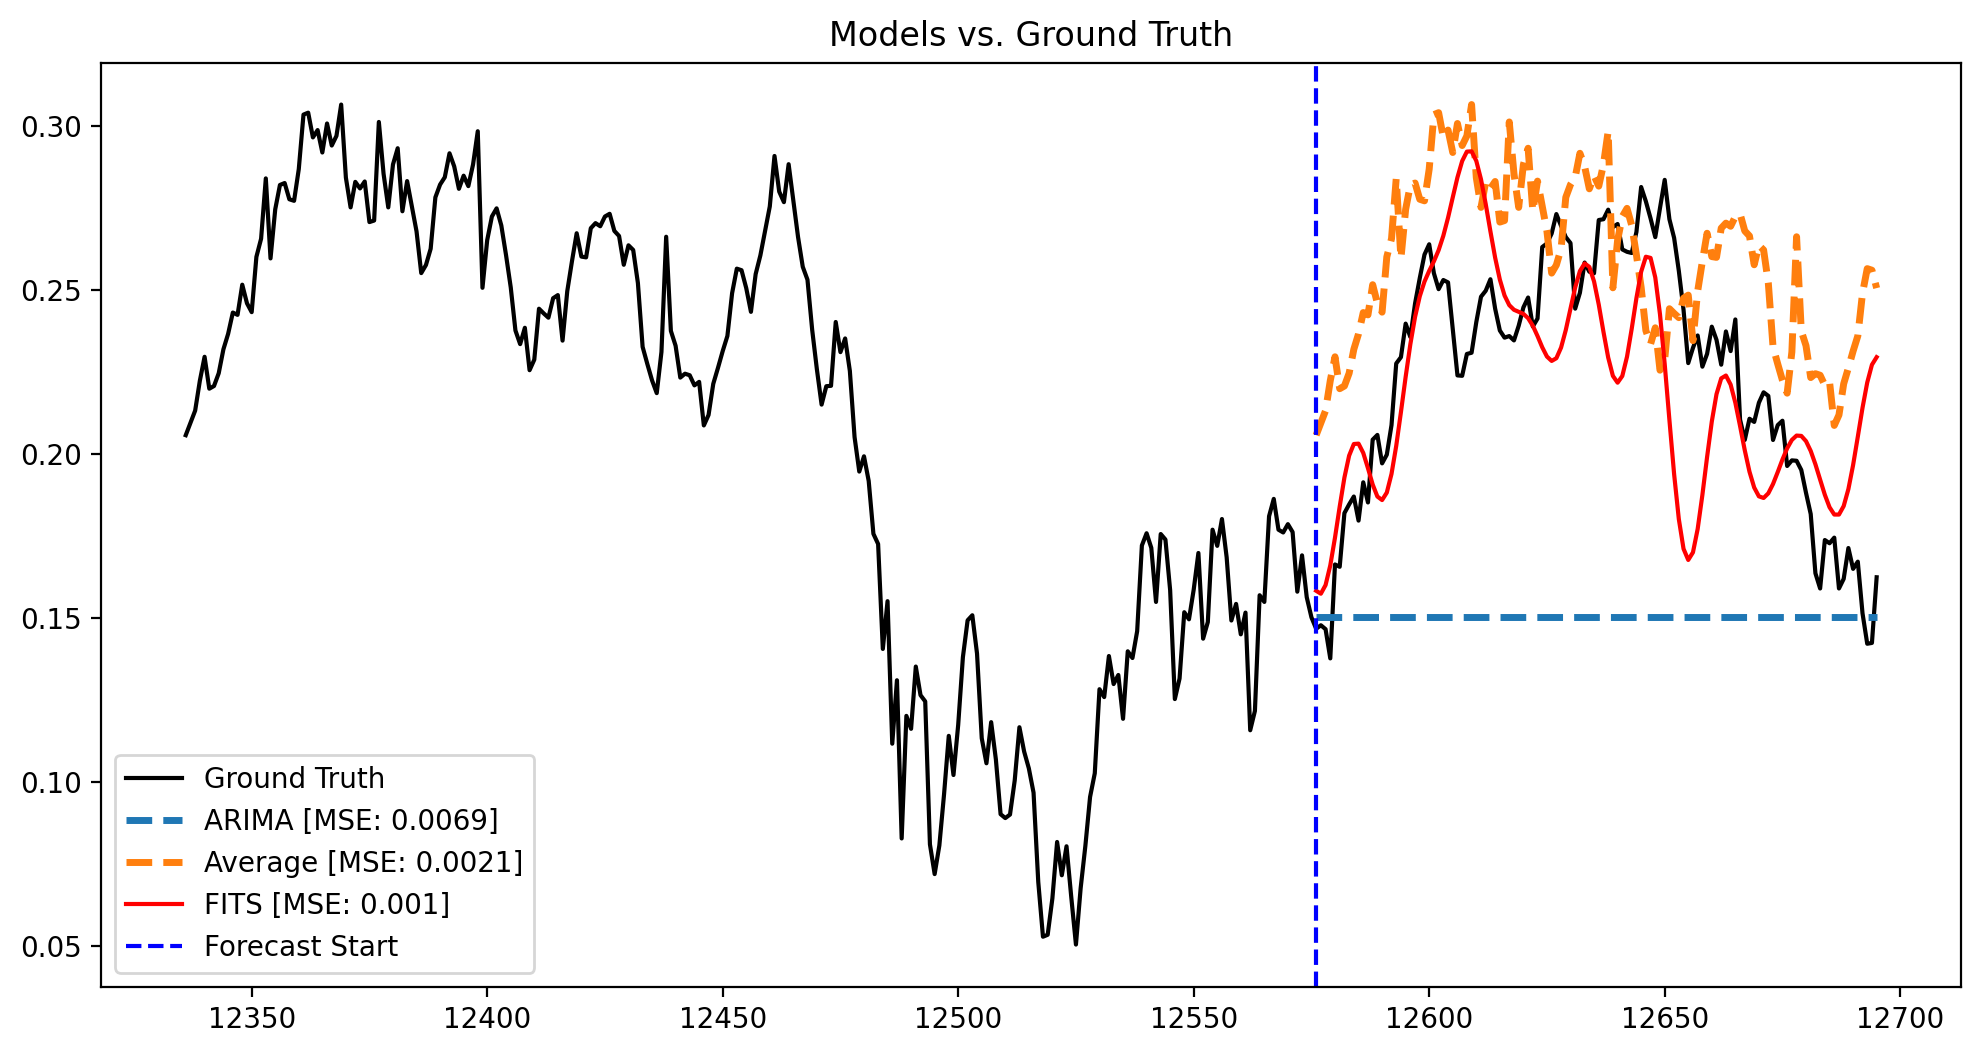

In [16]:
num_samples = len(y)
seq_len = args.seq_len
pred_len = args.pred_len

from models.ARIMA import ARIMA
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    

# Prepare the data
train_data = y[:int(num_samples * 0.8)]
test_data = y[int(num_samples * 0.8):]

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
naive = NaiveForecast(args_)
arima = ARIMA(args_)
average = AverageForecast(args_)

trained_models = [("ARIMA", arima), ("NF", naive), ("Average", average), ("FITS", fits)]

# Train and test the baseline models
start_index = int(num_samples * 0.8) - seq_len
end_index = int(num_samples * 0.8)

real_data = np.concatenate((train_data[start_index:], test_data[:pred_len]), axis=0)

plt.figure(figsize=(12, 6))
plt.plot(list(range(start_index, start_index + len(real_data))), real_data, label="Ground Truth", color="black")

# ARIMA
with torch.no_grad():
    def RMAE(output, target):
        return torch.sqrt(torch.mean(torch.abs(output - target)))

    criterion_mse = nn.MSELoss()
    criterion_rmae = RMAE

    arima.eval()
    test_loss_mse = []
    test_loss_rmae = []

    batch_x = torch.from_numpy(train_data[start_index:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    output = arima(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output = output[:, :pred_len, 0:]
    batch_y = batch_y[:, :pred_len, :]
    loss_mse = criterion_mse(output, batch_y)
    loss_rmae = criterion_rmae(output, batch_y)
    test_loss_mse.append(loss_mse.item())
    test_loss_rmae.append(loss_rmae.item())

plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"ARIMA [MSE: {round(loss_mse.item(),4)}]", linewidth=2.5, linestyle="--")

# # Naive Forecast
# with torch.no_grad():
#     naive.eval()
#     test_loss_mse = []
#     test_loss_rmae = []

#     batch_x = torch.from_numpy(train_data[start_index:].reshape(-1, seq_len, 1)).float()
#     batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
#     batch_xy = torch.cat([batch_x, batch_y], dim=1)
#     output = naive(batch_x)
#     if type(output) == torch.tensor:
#         output = output.detach().numpy()
#     batch_y = batch_y[:, :pred_len, :]
#     loss_mse = criterion_mse(output, batch_y)
#     loss_rmae = criterion_rmae(output, batch_y)
#     test_loss_mse.append(loss_mse.item())
#     test_loss_rmae.append(loss_rmae.item())

# plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"NF [MSE: {round(loss_mse.item(),4)}]", linewidth=2.5, linestyle="--")

# Average Forecast
with torch.no_grad():
    average.eval()
    test_loss_mse = []
    test_loss_rmae = []

    batch_x = torch.from_numpy(train_data[start_index:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    
    output = average(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    # output = output[:, 400:end_index, 0:]
    output = output[:, :pred_len, 0:]
    batch_y = batch_y[:, :pred_len, :]
    loss_mse = criterion_mse(output, batch_y)
    loss_rmae = criterion_rmae(output, batch_y)
    test_loss_mse.append(loss_mse.item())
    test_loss_rmae.append(loss_rmae.item())

plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"Average [MSE: {round(loss_mse.item(),4)}]", linewidth=2.5, linestyle="--")

# FITS
with torch.no_grad():
    fits.eval()
    test_loss_mse = []
    test_loss_rmae = []

    batch_x = torch.from_numpy(train_data[start_index:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    output = fits(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output = output[:, :pred_len, 0:]
    batch_y = batch_y[:, :pred_len, :]
    loss_mse = criterion_mse(output, batch_y)
    loss_rmae = criterion_rmae(output, batch_y)
    test_loss_mse.append(loss_mse.item())
    test_loss_rmae.append(loss_rmae.item())

plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"FITS [MSE: {round(loss_mse.item(),4)}]", color='red')

plt.axvline(x=end_index, color="blue", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("Models vs. Ground Truth")
plt.show()

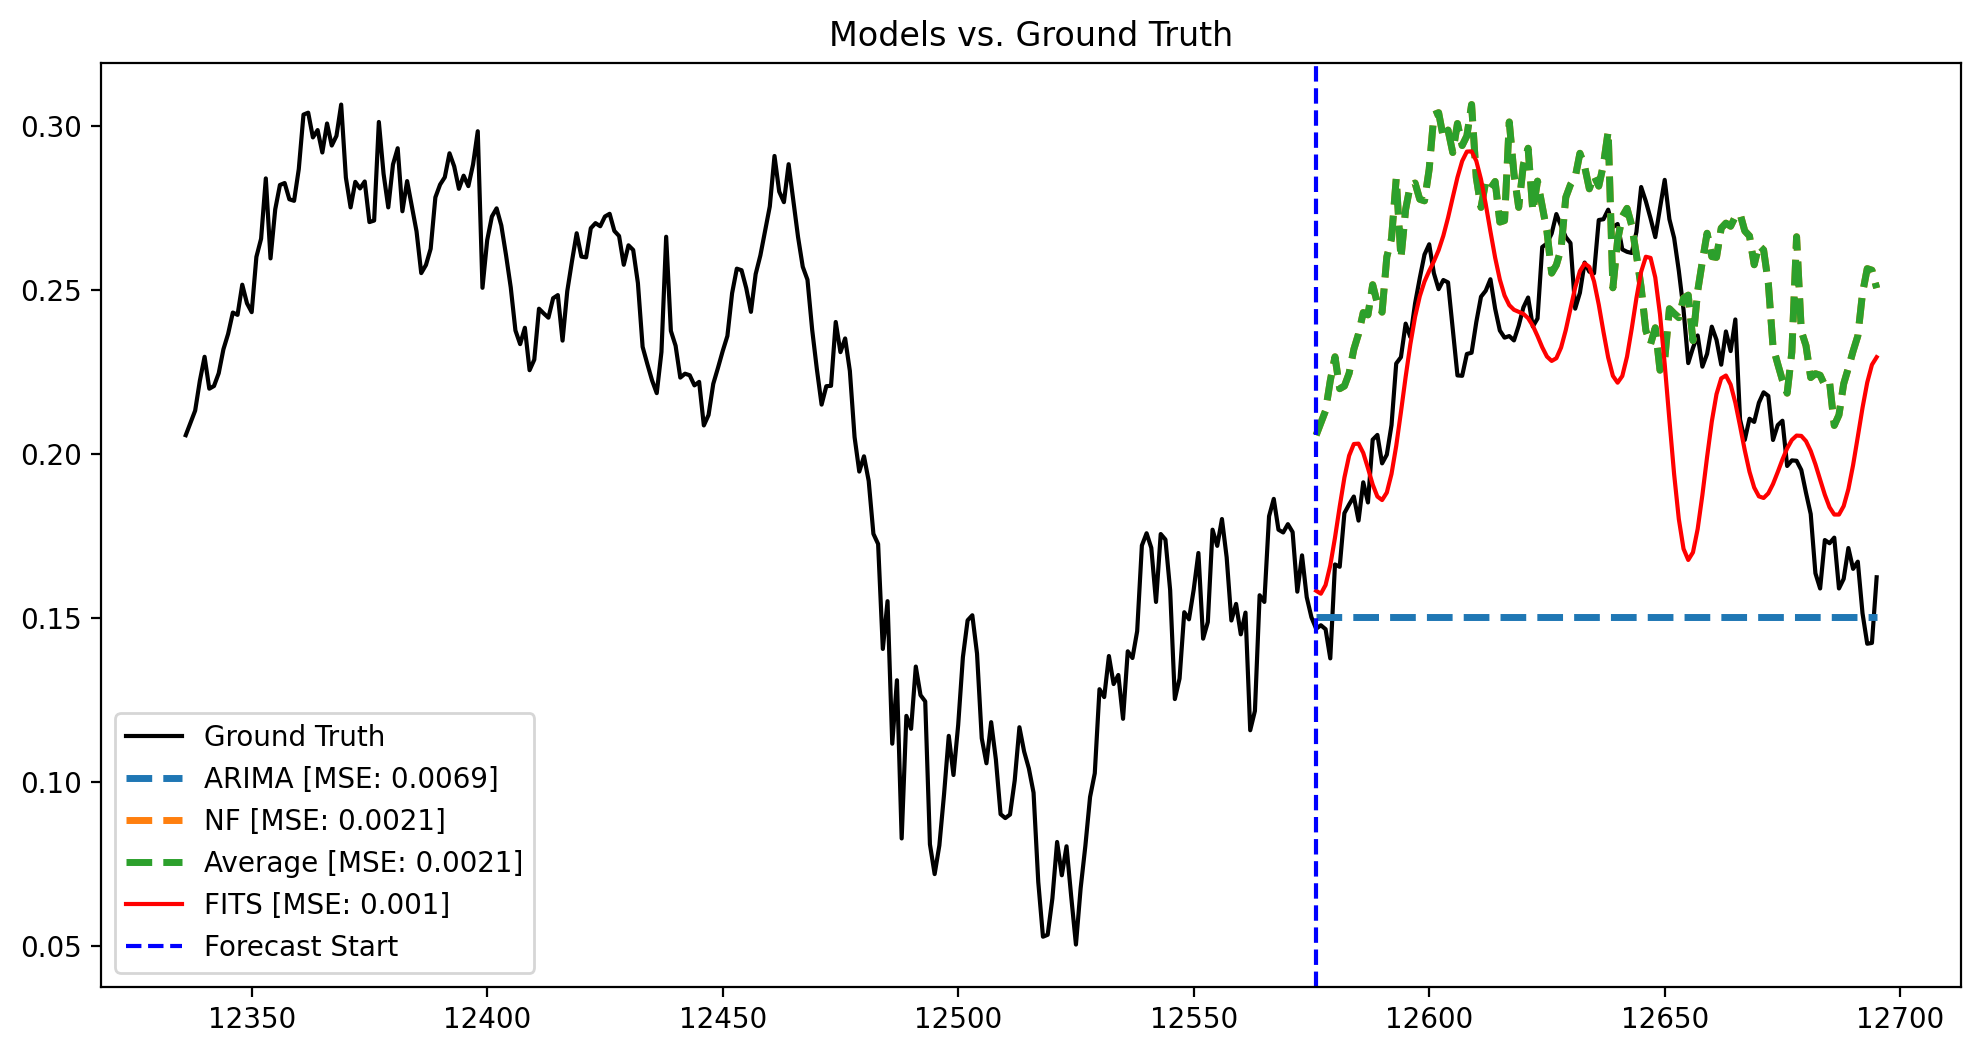

In [17]:
num_samples = len(y)
seq_len = args.seq_len
pred_len = args.pred_len

from models.ARIMA import ARIMA
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    
from models.FITS import FITS
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare the data
train_data = y[:int(num_samples * 0.8)]
test_data = y[int(num_samples * 0.8):]

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
naive = NaiveForecast(args_)
arima = ARIMA(args_)
average = AverageForecast(args_)

models = [("ARIMA", arima), ("NF", naive), ("Average", average), ("FITS", fits)]

# Train and test the baseline models
start_index = int(num_samples * 0.8) - seq_len
end_index = int(num_samples * 0.8)

real_data = np.concatenate((train_data[start_index:], test_data[:pred_len]), axis=0)

plt.figure(figsize=(12, 6))
plt.plot(list(range(start_index, start_index + len(real_data))), real_data, label="Ground Truth", color="black")

for name, model in models:
    with torch.no_grad():
        def RMAE(output, target):
            return torch.sqrt(torch.mean(torch.abs(output - target)))

        criterion_mse = nn.MSELoss()
        criterion_rmae = RMAE

        model.eval()
        test_loss_mse = []
        test_loss_rmae = []

        batch_x = torch.from_numpy(train_data[start_index:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = model(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        if name == "ARIMA" or "FITS":
            output = output[:, :pred_len, 0:]
        elif name == "Average":
            output = output[:, :pred_len, :]
        batch_y = batch_y[:, :pred_len, :]
        loss_mse = criterion_mse(output, batch_y)
        loss_rmae = criterion_rmae(output, batch_y)
        test_loss_mse.append(loss_mse.item())
        test_loss_rmae.append(loss_rmae.item())
    
    if name == "FITS":
        plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"{name} [MSE: {round(loss_mse.item(),4)}]", color='red')
    else:
        plt.plot(list(range(end_index, end_index + pred_len)), output[0, :, 0], label=f"{name} [MSE: {round(loss_mse.item(),4)}]", linewidth=2.5, linestyle="--")
    
plt.axvline(x=end_index, color="blue", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("Models vs. Ground Truth")
plt.show()